In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import tensorflow
import parquet
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error , mean_absolute_error , mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras.models import load_model

In [2]:
df = pd.read_parquet('kelusanka_2022_after imputing_missing.parquet')
len(df)

4745

In [3]:
hourly_train,hourly_test = df[['DEMAND']].iloc[:4342],df[['DEMAND']].iloc[4342:]
#hourly_train,hourly_test
print(len(hourly_train),len(hourly_test))

4342 403


In [4]:
scaler = MinMaxScaler()
scaler.fit(hourly_train)
scaled_hourly_train = scaler.transform(hourly_train)
scaled_hourly_test = scaler.transform(hourly_test)
len(scaled_hourly_train)

4342

In [5]:
n_input_hourly = 10
n_features = 1
def train_data_hourly(a,n):
    R,s=[],[]
    for i in range(len(scaled_hourly_train)):
        end_ix = i + n_input_hourly
        if end_ix > len(scaled_hourly_train)-1:
            break
        seq_r,seq_s = scaled_hourly_train[i:end_ix],scaled_hourly_train[end_ix]
        R.append(seq_r)
        s.append(seq_s)
    return np.array(R),np.array(s)
R,s = train_data_hourly(scaled_hourly_train,n_input_hourly)
R_train,R_val,s_train,s_val =train_test_split(R,s,test_size=0.15,shuffle = False,random_state = 0)

In [30]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=n_input_hourly))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [31]:
model.fit(R,s,epochs = 100, verbose = 2,batch_size = 32)

Epoch 1/100
136/136 - 0s - loss: 0.0233 - 382ms/epoch - 3ms/step
Epoch 2/100
136/136 - 0s - loss: 0.0128 - 81ms/epoch - 594us/step
Epoch 3/100
136/136 - 0s - loss: 0.0107 - 80ms/epoch - 587us/step
Epoch 4/100
136/136 - 0s - loss: 0.0102 - 80ms/epoch - 587us/step
Epoch 5/100
136/136 - 0s - loss: 0.0099 - 82ms/epoch - 601us/step
Epoch 6/100
136/136 - 0s - loss: 0.0093 - 81ms/epoch - 594us/step
Epoch 7/100
136/136 - 0s - loss: 0.0090 - 81ms/epoch - 594us/step
Epoch 8/100
136/136 - 0s - loss: 0.0089 - 80ms/epoch - 587us/step
Epoch 9/100
136/136 - 0s - loss: 0.0088 - 81ms/epoch - 594us/step
Epoch 10/100
136/136 - 0s - loss: 0.0084 - 81ms/epoch - 594us/step
Epoch 11/100
136/136 - 0s - loss: 0.0081 - 82ms/epoch - 601us/step
Epoch 12/100
136/136 - 0s - loss: 0.0080 - 83ms/epoch - 609us/step
Epoch 13/100
136/136 - 0s - loss: 0.0080 - 81ms/epoch - 594us/step
Epoch 14/100
136/136 - 0s - loss: 0.0079 - 83ms/epoch - 609us/step
Epoch 15/100
136/136 - 0s - loss: 0.0077 - 82ms/epoch - 604us/step
Epoch

In [32]:
#output test
last_train_batch = scaled_hourly_train[-n_input_hourly:]
last_train_batch = last_train_batch.reshape(1,n_input_hourly,n_features)
last_train_batch,model.predict(last_train_batch),scaled_hourly_test[0]

1/1 [==============================] - 0s 42ms/step


(array([[[0.1637931 ],
         [0.25862069],
         [0.24137931],
         [0.09482759],
         [0.12068966],
         [0.18965517],
         [0.48706897],
         [0.56465517],
         [0.60775862],
         [0.06465517]]]),
 array([[0.23606688]], dtype=float32),
 array([0.26293103]))

In [33]:
hourly_predictions = []
first_eval_batch = scaled_hourly_train[-n_input_hourly:]
current_batch = first_eval_batch.reshape(1,n_input_hourly,n_features)

for i in range(len(scaled_hourly_test)):
    # get the prediction value for first batch
    current_pred = model.predict(current_batch)[0]
    
    # appending the prediction into array
    hourly_predictions.append(current_pred)
    
    #updating the batch with the predicted value and removing the first element
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)
    
#hourly_predictions

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


In [34]:
scaled_hourly_test1 = scaler.inverse_transform(scaled_hourly_test)
scaled_hourly_test2 = pd.DataFrame(scaled_hourly_test1)
true_predictions = scaler.inverse_transform(hourly_predictions)
scaled_hourly_test2['predictions'] = np.round(true_predictions)
scaled_hourly_test2

,0,predictions
0,62.0,56.0
1,162.0,152.0
2,63.0,55.0
3,26.0,30.0
4,59.0,54.0
...,...,...
398,75.0,75.0
399,90.0,120.0
400,106.0,120.0
401,138.0,119.0


rmse: 22.02215216785631
mae: 16.315136476426797
mape: 25.983914264106883
wmape: 20.851833058480274


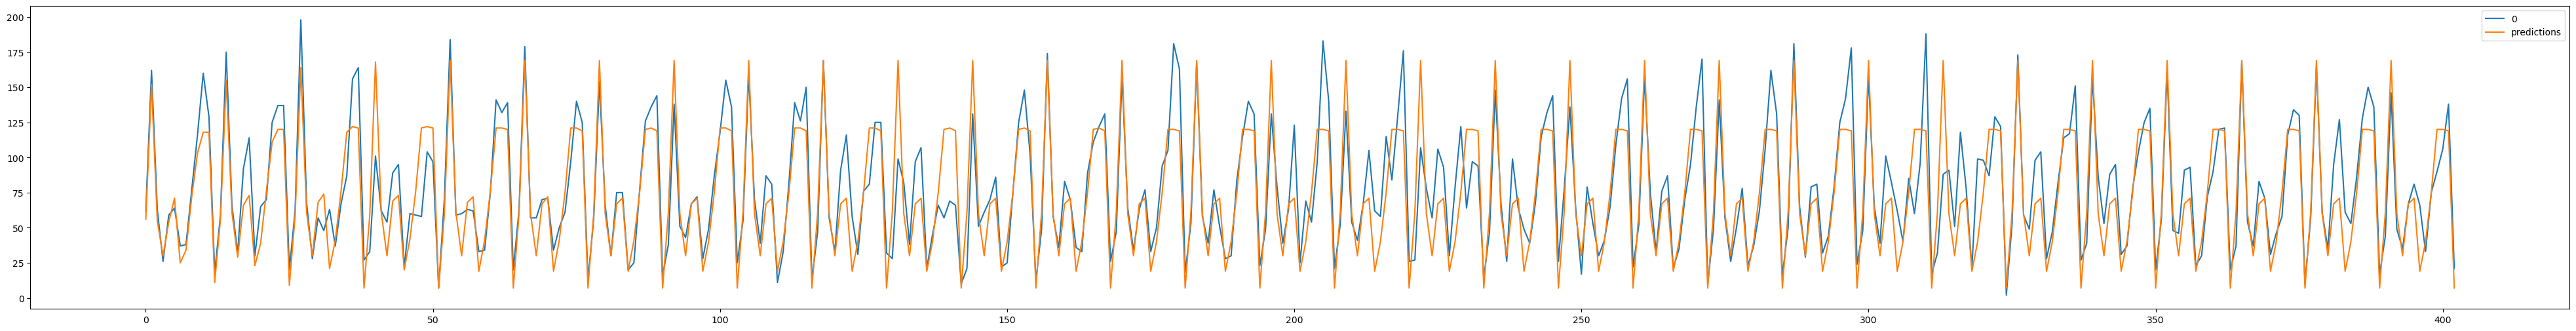

In [35]:
scaled_hourly_test2.plot(kind = 'line',figsize =(50,6))
rmse = sqrt(mean_squared_error(scaled_hourly_test2[0],scaled_hourly_test2['predictions']))
print('rmse:',rmse)
print('mae:',mean_absolute_error(scaled_hourly_test2[0],scaled_hourly_test2['predictions']))
#MAPE should be less than 10
mape = (1/len(scaled_hourly_test2))*np.sum(np.abs((scaled_hourly_test2[0]-scaled_hourly_test2['predictions'])/scaled_hourly_test2[0]))*100
print('mape:',mape)
wmape = np.sum((scaled_hourly_test2[0]/np.sum(scaled_hourly_test2[0]))*(np.abs((scaled_hourly_test2[0]-scaled_hourly_test2['predictions'])/scaled_hourly_test2[0])))*100
print('wmape:',wmape)

In [37]:
model.save('comparison_with_ann.h5')

In [ ]:
model = load_model('comparison_with_ann.h5')